# Credit Card Fraud Prediction using Neural Network

It is crucial for credit card providers to accurately recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

This project aims to build a neural network for predicting credit card fraudulent transactions using a dataset with given features.

The dataset can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

This dataset holds information about transactions made by credit cards in September 2013 by European cardholders that occurred in two days, where **492** frauds  are recorded out of 284,807 transactions.

### 1. Data preprocessing

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,...,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,...,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,...,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,...,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,...,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
          ...  
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
Length: 31, dtype: bool

### 2. Data Visualization

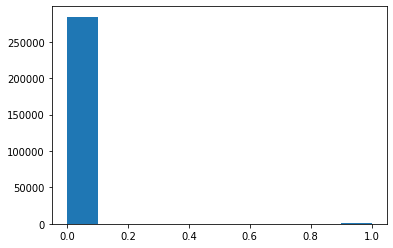

In [5]:
data.Class.hist(grid=False);

In [6]:
Class = data.groupby('Class').size()
Class

Class
0    284315
1       492
dtype: int64

As observed in the histogram, this dataset is highly imbalanced, where fraudulent transactions is only 0.17% out of all recorded transactions.

This can negatively affect our model, where it might perform better at predicting the outcome of valid transactions (the majority occurence), but will not be able to predict fraud transactions as accurately.

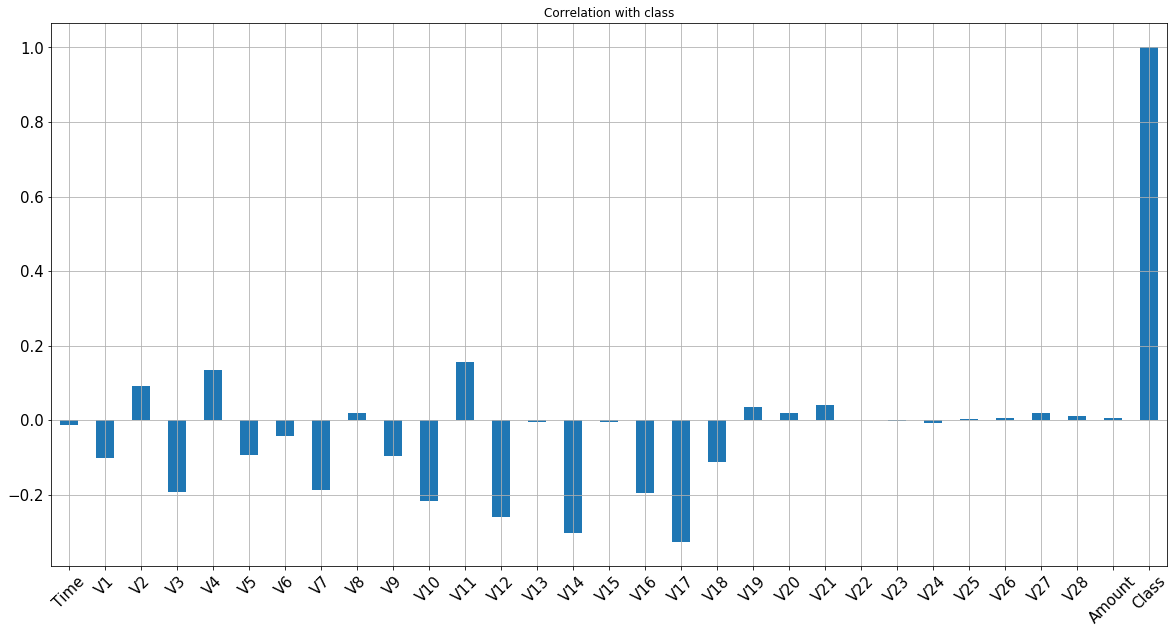

In [7]:
data.corrwith(data.Class).plot.bar(
        figsize=(20, 10), title="Correlation with class",
        fontsize=15, rot=45, grid=True);

### 3. Data preparation

We will perform scaling on the `Amount` of transaction, and we will remove the `Time` feature from the dataset.

`RobustScaler()` is used for scaling.

In [8]:
from sklearn.preprocessing import RobustScaler

robust_scale = RobustScaler()

data['scaled_amount'] = robust_scale.fit_transform(data['Amount'].values.reshape(-1,1))
data.drop(['Time','Amount'], axis=1, inplace=True)

In [9]:
X = data.drop(columns='Class')
y = data['Class']

The dataset is split with 70:30 ratio between train and test set.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

### 4. Evaluation

For the evaluation of this model, we will be using the **confusion matrix** and **precision-recall**.

#### 4.1 Confusion Matrix

Below is an example of a confusion matrix.

![Confusion Matrix](http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

**True Positives**: The model correctly classifies a fraud transaction as a fraud.

**True Negatives**: This is the number of correctly classifications of the "No" (Valid) class.

**False Negatives**: Valid transaction predicted as fraud. 

**False Positives**: Fraud transaction predicted as valid. 




We will also define a function to visualize our confusion matrices.

In [12]:
from sklearn.metrics import confusion_matrix

import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 4.2 Area Under Precision-Recall Curve

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly. [(Documentation)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

### 5. Neural Network 

We will be building a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (Valid or fraud).

In [14]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import warnings

Using TensorFlow backend.


In [15]:
n_inputs = X_train.shape[1]

In [16]:
warnings.filterwarnings('ignore')

model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary();

model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy']);

model.fit(X_train, y_train, validation_split=0.2, batch_size=300, epochs=50, shuffle=True);


W0716 18:37:43.944529  2536 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 18:37:43.958487  2536 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 18:37:43.960444  2536 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 18:37:44.015333  2536 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0716 18:37:44.020322  2536 deprecation_wrapper.py:119] From C:\ProgramData\Anac

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                960       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,896
Trainable params: 1,896
Non-trainable params: 0
_________________________________________________________________
Train on 159491 samples, validate on 39873 samples
Epoch 1/50
159491/159491 [==============================] - 1s 5us/step - loss: 0.0422 - acc: 0.9933 - val_loss: 0.0042 - val_acc: 0.9991
Epoch 2/50
159491/159491 [==============================] - 1s 4us/step - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0025 - val_acc: 0.9995
Epoch 3/50
159491/159491 [==============================] - 1s 4us/step - los

In [17]:
predictions = model.predict(X_test, batch_size=200, verbose=0)

fraud_predictions = model.predict_classes(X_test, batch_size=200)

In [18]:
model_confusion = confusion_matrix(y_test, fraud_predictions)
actual_cm = confusion_matrix(y_test, y_test.round())

Confusion matrix, without normalization
[[85246    35]
 [   37   125]]
Confusion matrix, without normalization
[[85281     0]
 [    0   162]]


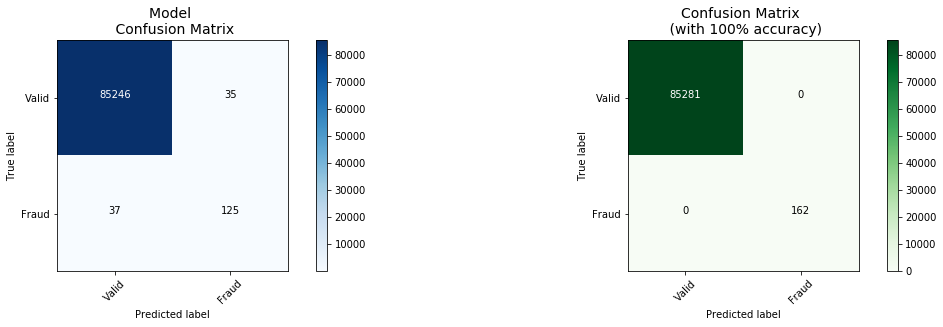

In [19]:
fig = plt.figure(figsize=(16,8))
labels = ['Valid', 'Fraud']
fig.add_subplot(221)
plot_confusion_matrix(model_confusion, labels, title="Model \n Confusion Matrix", cmap=plt.cm.Blues);

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens);

In [20]:
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

score = average_precision_score(y_test, fraud_predictions) 

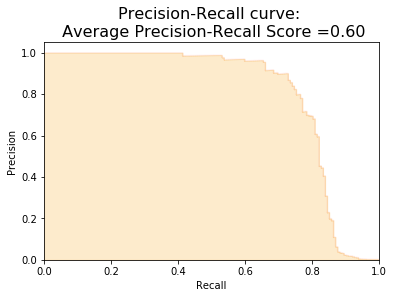

In [21]:
plt.step(recall, precision, color='r', alpha=0.05,
         where='post');
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00');

plt.xlabel('Recall');
plt.ylabel('Precision');
plt.ylim([0.0, 1.05]);
plt.xlim([0.0, 1.0]);
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(score), fontsize=16);

### Synthetic Minority Oversampling Technique (SMOTE)

As stated earlier, the dataset is highly unbalanced. A method that could improve our model is **oversampling.**

We will be using Synthetic Minority Oversampling Technique or *SMOTE* for this dataset.

The way *SMOTE* works:
- It finds the n-nearest neighbors in the minority class for each of the samples in the class.
- It draws a line between the the neighbors
- It generates random synthetic points on the lines.

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_resample, y_resample = SMOTE().fit_sample(X,y.values.ravel())

Xsmote_train, Xsmote_test, ysmote_train, ysmote_test = train_test_split(X_resample,y_resample,test_size=0.3)

In [23]:
#Deep Neural Network + SMOTE

In [24]:
oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                960       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 1,896
Trainable params: 1,896
Non-trainable params: 0
_________________________________________________________________


In [25]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
oversample_model.fit(Xsmote_train, ysmote_train, validation_split=0.2, batch_size=300, epochs=50, shuffle=True)

Train on 318432 samples, validate on 79609 samples
Epoch 1/50
318432/318432 [==============================] - 1s 4us/step - loss: 0.0893 - acc: 0.9630 - val_loss: 0.0344 - val_acc: 0.9896
Epoch 2/50
318432/318432 [==============================] - 1s 4us/step - loss: 0.0238 - acc: 0.9930 - val_loss: 0.0174 - val_acc: 0.9953
Epoch 3/50
318432/318432 [==============================] - 1s 4us/step - loss: 0.0140 - acc: 0.9965 - val_loss: 0.0120 - val_acc: 0.9974
Epoch 4/50
318432/318432 [==============================] - 1s 4us/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0089 - val_acc: 0.9982
Epoch 5/50
318432/318432 [==============================] - 1s 4us/step - loss: 0.0075 - acc: 0.9984 - val_loss: 0.0074 - val_acc: 0.9987
Epoch 6/50
318432/318432 [==============================] - 1s 4us/step - loss: 0.0062 - acc: 0.9986 - val_loss: 0.0071 - val_acc: 0.9988
Epoch 7/50
318432/318432 [==============================] - 1s 4us/step - loss: 0.0050 - acc: 0.9989 - val_loss: 0.0072 -

In [27]:
oversample_predictions = oversample_model.predict_classes(X_test, batch_size=200, verbose=0)

In [28]:
oversample_confusion = confusion_matrix(y_test, oversample_predictions)
actual_cm = confusion_matrix(y_test, y_test)

Confusion matrix, without normalization
[[85246    35]
 [    0   162]]
Confusion matrix, without normalization
[[85281     0]
 [    0   162]]


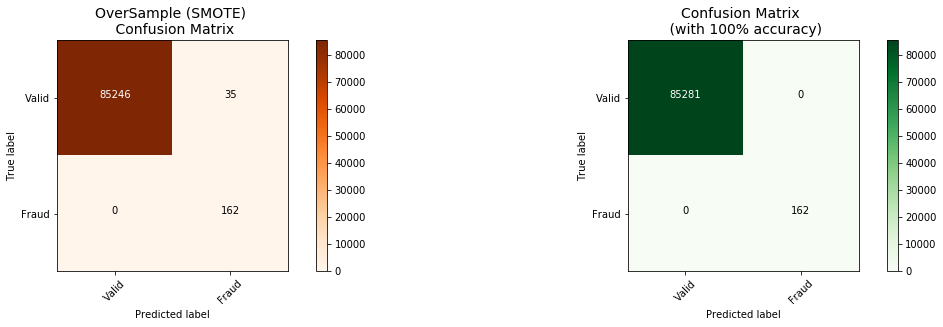

In [29]:
fig = plt.figure(figsize=(16,8))
labels = ['Valid', 'Fraud']

fig.add_subplot(221)
plot_confusion_matrix(oversample_confusion, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges);

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens);

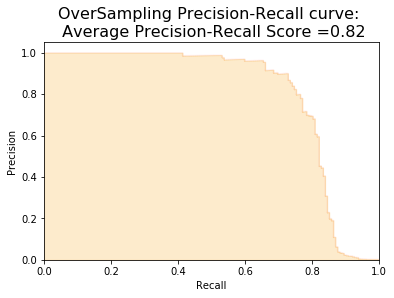

In [30]:
oversample_score = average_precision_score(y_test, oversample_predictions) 

plt.step(recall, precision, color='r', alpha=0.05,
         where='post');
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00');

plt.xlabel('Recall');
plt.ylabel('Precision');
plt.ylim([0.0, 1.05]);
plt.xlim([0.0, 1.0]);
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(oversample_score), fontsize=16);

### Remarks

After carrying out the project, several observations can be made.

- Confusion matrix is important in understanding what is at stake if the model made an incorrect prediction. In this case, false negative could mean that customers might get their card blocked while performing a completely normal transaction. This could lead to dissatisfaction and potential churn. A false positive could mean that both the credit card provider and the customer are losing money due to a fraudulent transaction.

- Imbalanced data is common in the real world. Techniques such as oversampling can be handy in improving the model.

- For further exploration, different neural network configuration can be used to obtain better performance.